### Theoretical limit

In [20]:
def theory_limit(n):
    return 1/4*(4**n-3*n-1)
def qsd_limit(n):
    return 23/48*(4**n)-3/2*(2**n)+4/3
qsd_limit(4)

100.0

### Cost function

In [21]:
import numpy as np
import scipy
def c_hst(U,V):
    d = U.shape[0]
    return 1 - 1/(d**2)*(np.abs(np.trace(np.conjugate(np.transpose(V))@U)))**2
def f_hat(U,V):
    d = U.shape[0]
    return 1 - d/(d + 1) * c_hst(U,V)
def frobenius(U,V):
    return 1/2*np.linalg.norm(V - U,'fro')
def frobenius_fidelity(U,V):
    d = U.shape[0]
    return 1 - d/(d + 1) + 1/(d*(d+1))*(d - frobenius(U,V))**2

u = np.random.rand(8, 8)
q, r = np.linalg.qr(u)
import time
start = time.time()
(frobenius_fidelity(q,q))
end = time.time()
print(end - start)

3.719329833984375e-05


### Circuit

In [22]:
import qiskit
from qiskit.quantum_info import Operator

def mcx_gate(num_qubits):
    mcx_gate = qiskit.circuit.library.MCXGate(num_qubits - 1)
    return np.real(Operator(mcx_gate).data)

def U3cry(num_qubits: int, num_layers: int, thetas: qiskit.circuit.ParameterVector, active_gates: np.ndarray) -> tuple[qiskit.QuantumCircuit, np.ndarray]:
    qc = qiskit.QuantumCircuit(num_qubits)
    k = 0
    index_params = 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if active_gates[k] == 1:
                    qc.u(thetas[index_params],thetas[index_params + 1],thetas[index_params + 2],i)
                    index_params += 3
                if active_gates[k + 1] == 1:
                    qc.u(thetas[index_params],thetas[index_params + 1],thetas[index_params + 2],j)
                    index_params += 3
                if active_gates[k + 2] == 1:
                    qc.cry(thetas[index_params], j, i)
                    index_params += 1
                k += 3
                qc.barrier()
    return qc, qiskit.quantum_info.Operator(qc).data # .draw('mpl')

In [32]:
import qiskit
import qiskit.quantum_info
from qoop.core.optimizer import adam
%load_ext autoreload
%autoreload 2
import constant
def num_params_on_active_gates(active_gates):
    num_params = 0
    for i in range(0, len(active_gates), 3):
        num_params += (active_gates[i] + active_gates[i+1]) * 3
        num_params += active_gates[i + 2] * 1
    return int(num_params)
def target_func(num_qubits, num_layers, active_gates):
    
    thetas = np.ones(num_params_on_active_gates(active_gates))
    costs, thetass = [], []
    def objective(thetas):
        _, U = U3cry(num_qubits, num_layers, thetas, active_gates)
        return c_hst(U, mcx_gate(num_qubits))
    for iter in range(constant.num_iterations):
        cost = objective(thetas)
        if cost < constant.error:
            break
        costs.append(cost)
        thetass.append(thetas)
        grad = np.zeros(len(thetas))
        for j in range(0, len(thetas)):
            thetas_plus = thetas.copy()
            thetas_plus[j] += constant.shift
            thetas_minus = thetas.copy()
            thetas_minus[j] -= constant.shift
            grad[j] = (objective(thetas_plus) - objective(thetas_minus))/(2*constant.shift)
        if iter == 0:
            m, v1 = list(np.zeros(thetas.shape[0])), list(
                np.zeros(thetas.shape[0]))
        thetas = adam(thetas, m, v1, iter, grad)
    return costs, thetass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
num_qubits = 3
num_layers = 5
active_gates = np.ones(3 * (num_qubits*(num_qubits-1)//2) * num_layers) # num_blocks = num_qubits*(num_qubits-1)//2
costs, _ = target_func(num_qubits, num_layers, active_gates)


0.961869597317977
0.9619703072374198
0.8664134696234569
0.7937142592355811
0.7649539481625878
0.7061063782060529
0.620204846886385
0.5401844064815499
0.47251451351046003
0.3967714510601926
0.3060189473229268
0.23389946379288806
0.17696252111979416
0.1515190595602275
0.1268928308171008
0.10027318987128653
0.07962987922825582
0.06692233713108231
0.05830129043034171
0.052578987316757586
0.04816718231167383
0.042788684515965625
0.037948792340395276
0.03248635709585257
0.03189635980076211
0.030702647229791102
0.02634883764527607
0.02018152515869609
0.024172957662183192
0.02935419019975971
0.020206672210610566
0.012020636299424292
0.020701556378319497
0.038451898663329875
0.04426967072393684
0.019028141361797757
0.012924859660409238
0.025394033340859212
0.011952333157332018
0.007861154444156027
0.01607035000660406
0.008776825742232708
0.006312699761501617
0.009836911490480493
0.0065467710700098936
0.005622721021811938
0.0066994663983306335
0.004583978809423628
0.004091251540183194
0.00516415

0.961869597317977


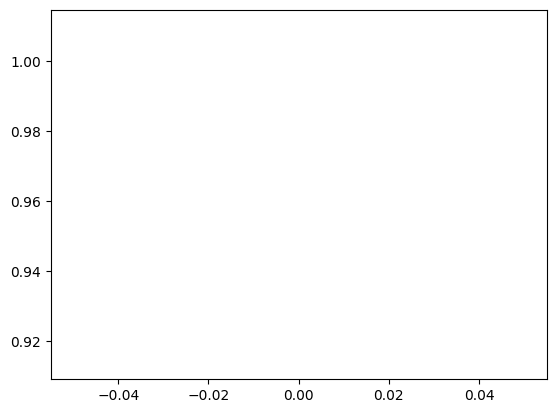

In [25]:
import matplotlib.pyplot as plt
print(costs[-1])
plt.plot(costs)

18
40


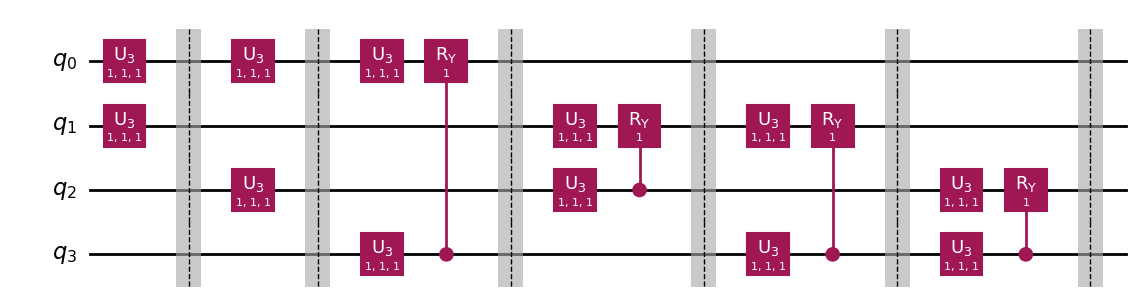

In [26]:
import qiskit
num_qubits = 4
num_layers = 1
num_blocks = num_qubits*(num_qubits-1)//2
active_gates = np.ones(3*num_blocks*num_layers)
active_gates[2] = 0
active_gates[5] = 0
thetas = np.ones(num_params_on_active_gates(active_gates))
print(len(active_gates))
print(len(thetas))
qc_x, _ = U3cry(num_qubits, num_layers, thetas, active_gates)
qc_excipilit = qiskit.transpile(qc_x, basis_gates=['u3','cry'], optimization_level=1)
qc_excipilit.draw('mpl')